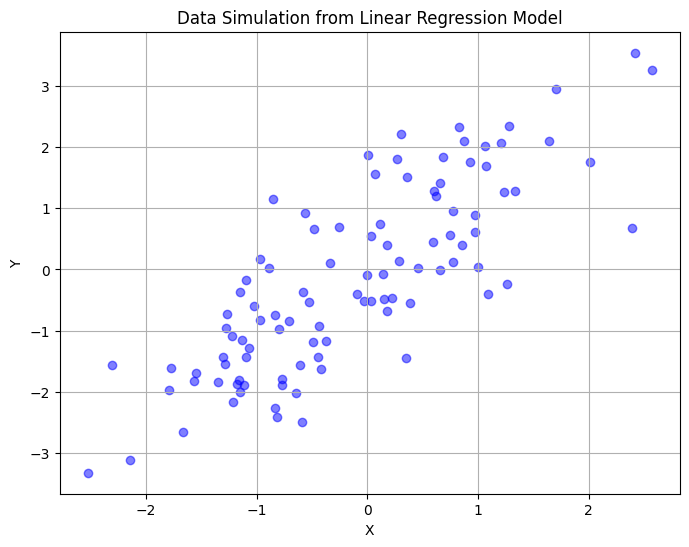

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n = 100
beta = 1
sigma_epsilon = 1

# Simulating data
X = np.random.normal(0, 1, n) # X ~ N(0, 1)
epsilon = np.random.normal(0, sigma_epsilon, n) # epsilon ~ N(0, sigma_epsilon^2)
Y = beta * X + epsilon

# Plotting the data pairs
plt.figure(figsize=(8, 6))
plt.scatter(X, Y, color='blue', alpha=0.5)
plt.title('Data Simulation from Linear Regression Model')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()


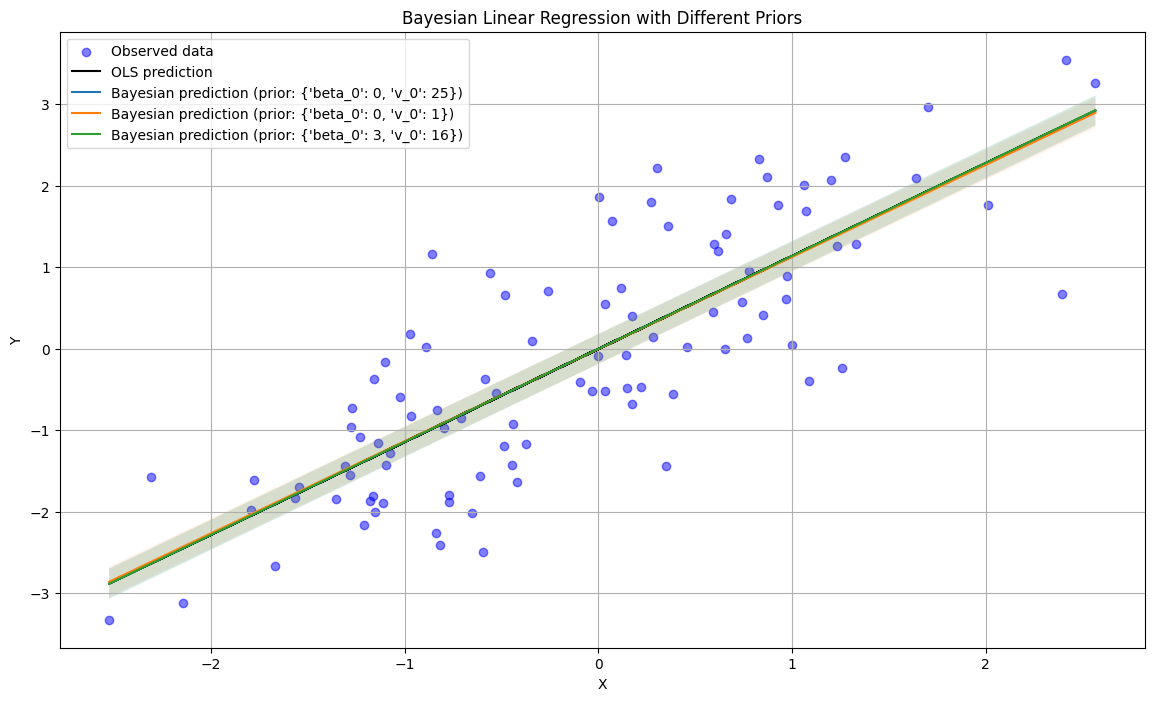

In [2]:
from scipy.stats import norm

# Constants for priors and noise variance
sigma_e_squared = 1
priors = [
    {'beta_0': 0, 'v_0': 25},
    {'beta_0': 0, 'v_0': 1},
    {'beta_0': 3, 'v_0': 16},
]

# Calculate beta hat from standard linear regression (OLS)
X_with_intercept = np.c_[np.ones(n), X]  # Adding intercept term
beta_hat_ols = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ Y

# Function to calculate posterior mean and variance
def calculate_posterior(X, Y, beta_0, v_0, sigma_e_squared):
    X_with_intercept = np.c_[np.ones(len(X)), X]  # Adding intercept term
    V_n_inv = (1/v_0) * np.eye(2) + (1/sigma_e_squared) * X_with_intercept.T @ X_with_intercept
    V_n = np.linalg.inv(V_n_inv)
    beta_n = V_n @ ((1/v_0) * beta_0 + (1/sigma_e_squared) * X_with_intercept.T @ Y)
    return beta_n, V_n

# Calculating posteriors
posterior_means = []
posterior_variances = []
for prior in priors:
    beta_n, V_n = calculate_posterior(X, Y, prior['beta_0'], prior['v_0'], sigma_e_squared)
    posterior_means.append(beta_n)
    posterior_variances.append(V_n[1, 1])  # Variance of beta

# Plotting
plt.figure(figsize=(14, 8))

# Scatter plot of the observed data
plt.scatter(X, Y, color='blue', alpha=0.5, label='Observed data')

# Plot OLS regression line
ols_line = beta_hat_ols[0] + beta_hat_ols[1] * X
plt.plot(X, ols_line, color='black', label='OLS prediction')

# Plot Bayesian predictions with confidence intervals
x_values = np.linspace(min(X), max(X), 100)
for i, prior in enumerate(priors):
    beta_n = posterior_means[i]
    variance_n = posterior_variances[i]
    bayesian_line = beta_n[0] + beta_n[1] * x_values
    plt.plot(x_values, bayesian_line, label=f'Bayesian prediction (prior: {prior})')
    
    # 95% confidence interval for the Bayesian predictions
    ci = 1.96 * np.sqrt(variance_n)  # 95% CI
    plt.fill_between(x_values, bayesian_line - ci, bayesian_line + ci, alpha=0.1)

plt.title('Bayesian Linear Regression with Different Priors')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()


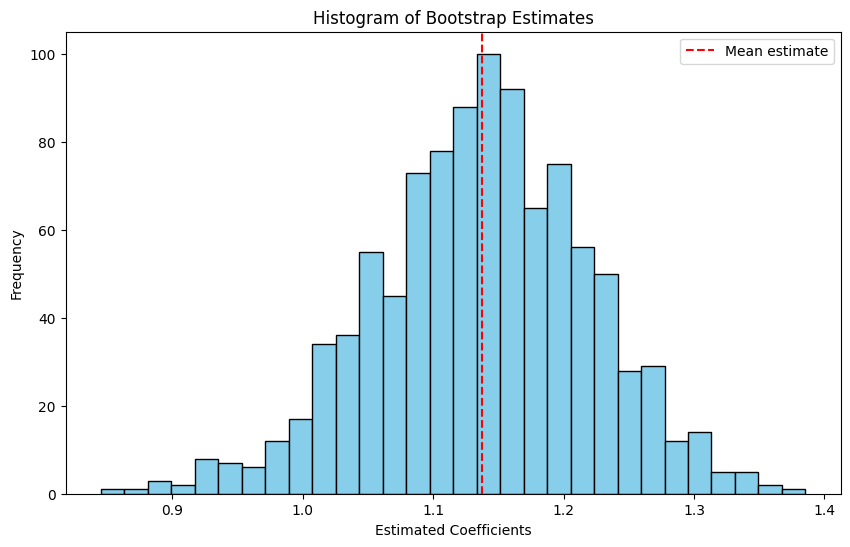

{'Bootstrap Std': 0.08311992533916056,
 'Posterior Variances': [0.008767388820199673,
  0.008692951629937766,
  0.008765629331093577]}

In [3]:
from sklearn.utils import resample

# Number of bootstrap samples
B = 1000

# Bootstrap
bootstrap_estimates = np.zeros(B)
for i in range(B):
    # Resample the data
    X_resampled, Y_resampled = resample(X, Y)
    # Calculate beta hat for the resampled data
    X_resampled_with_intercept = np.c_[np.ones(len(X_resampled)), X_resampled]
    beta_hat_resampled = np.linalg.inv(X_resampled_with_intercept.T @ X_resampled_with_intercept) \
                         @ X_resampled_with_intercept.T @ Y_resampled
    bootstrap_estimates[i] = beta_hat_resampled[1]  # Store the slope coefficient

# Calculate the standard deviation of bootstrap estimates
bootstrap_std = np.std(bootstrap_estimates)

# Compare with the variances of the posterior from Task 2
comparison = {'Bootstrap Std': bootstrap_std, 'Posterior Variances': posterior_variances}

# Plot histogram of bootstrap estimates
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_estimates, bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=np.mean(bootstrap_estimates), color='red', linestyle='--', label='Mean estimate')
plt.title('Histogram of Bootstrap Estimates')
plt.xlabel('Estimated Coefficients')
plt.ylabel('Frequency')
plt.legend()
plt.show()

comparison


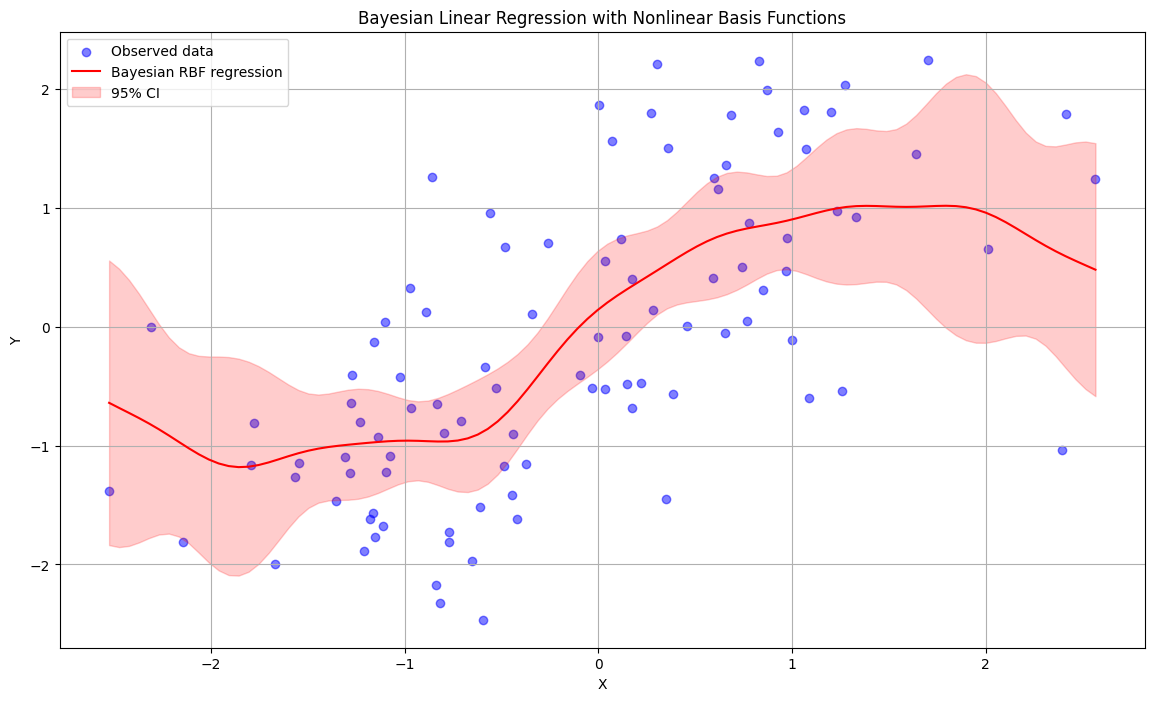

In [4]:
from scipy.interpolate import Rbf

# Generate the data
Y = np.sin(X) + epsilon

# Define the RBFs
rbf_centers = np.linspace(min(X), max(X), 9)
rbf_width = (rbf_centers[1] - rbf_centers[0]) / 2

# Transform the data using RBFs
def rbf_transform(X, rbf_centers, rbf_width):
    X_transformed = np.zeros((len(X), len(rbf_centers)))
    for i, center in enumerate(rbf_centers):
        X_transformed[:, i] = np.exp(-((X - center) ** 2) / (2 * rbf_width ** 2))
    return X_transformed

X_transformed = rbf_transform(X, rbf_centers, rbf_width)
X_transformed_with_intercept = np.c_[np.ones(n), X_transformed]  # Adding intercept term

# Apply Bayesian linear regression to the RBF-transformed data
beta_0 = np.zeros(X_transformed_with_intercept.shape[1])  # prior mean
V_0 = np.eye(X_transformed_with_intercept.shape[1])  # prior variance-covariance matrix

# Calculate posterior mean and variance
V_n_inv = np.linalg.inv(V_0) + (1/sigma_e_squared) * X_transformed_with_intercept.T @ X_transformed_with_intercept
V_n = np.linalg.inv(V_n_inv)
beta_n = V_n @ ((1/sigma_e_squared) * X_transformed_with_intercept.T @ Y)

# Predictions
X_plot = np.linspace(min(X), max(X), 100)
X_plot_transformed = rbf_transform(X_plot, rbf_centers, rbf_width)
X_plot_transformed_with_intercept = np.c_[np.ones(len(X_plot)), X_plot_transformed]
Y_pred = X_plot_transformed_with_intercept @ beta_n

# 95% Confidence interval
Y_pred_std = np.sqrt(np.diag(X_plot_transformed_with_intercept @ V_n @ X_plot_transformed_with_intercept.T))

# Plotting
plt.figure(figsize=(14, 8))
plt.scatter(X, Y, color='blue', alpha=0.5, label='Observed data')
plt.plot(X_plot, Y_pred, color='red', label='Bayesian RBF regression')
plt.fill_between(X_plot, Y_pred - 1.96 * Y_pred_std, Y_pred + 1.96 * Y_pred_std, color='red', alpha=0.2, label='95% CI')
plt.title('Bayesian Linear Regression with Nonlinear Basis Functions')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()
